# Nb-20180313-2044-RandomForest-GainPrediction

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day.

Try adding in normalied Volume data plus Bollinger Bands to see how that changes precision. 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from collections import defaultdict
import operator

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
import finance as fat

In [6]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [7]:
ticker = 'IBM'

In [8]:
raw = fat.get_price_data(ticker)
ohlcv = raw

Loaded data for IBM: 1970-01-02 to 2018-03-12.


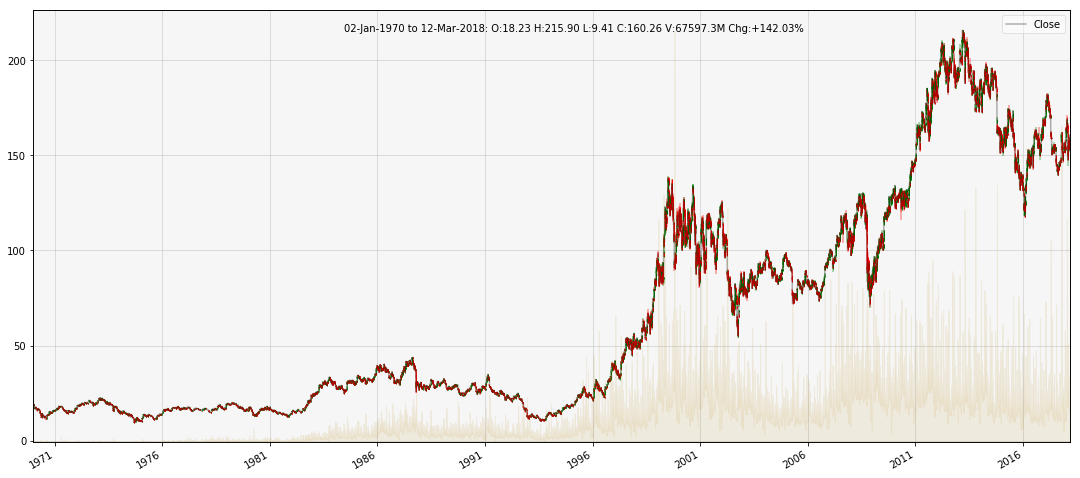

In [9]:
fat.plot_daily_ticker(ohlcv)

In [10]:
raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,18.225000,18.287500,18.200001,18.237499,1.689605,315200
1970-01-05,18.299999,18.412500,18.299999,18.412500,1.705818,424000
1970-01-06,18.412500,18.450001,18.312500,18.424999,1.706977,488000
1970-01-07,18.424999,18.437500,18.312500,18.437500,1.708133,457600
1970-01-08,18.437500,18.475000,18.375000,18.475000,1.711608,707200


### Price and Created Features

Scale the OHLC data to match 'Adj Close'

In [11]:
data = raw.copy()
data = data.div((data['Close']/data['Adj Close']), axis=0)
del data['Adj Close']
del data['Volume']
data.head()

,Open,High,Low,Close
Date,,,,
1970-01-02,1.688447,1.694237,1.686131,1.689605
1970-01-05,1.695395,1.705818,1.695395,1.705818
1970-01-06,1.705819,1.709293,1.696555,1.706977
1970-01-07,1.706975,1.708133,1.696552,1.708133
1970-01-08,1.708134,1.711608,1.702344,1.711608


Get table with prices for last 5 days, and price for following day.

In [12]:
for i in range(-5, 0, 1) :
    data[f'Close {i}d'] = data['Close'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d
Date,,,,,,,,,
1970-01-09,1.711607,1.716239,1.706975,1.709291,1.689605,1.705818,1.706977,1.708133,1.711608
1970-01-12,1.709292,1.712766,1.703502,1.703502,1.705818,1.706977,1.708133,1.711608,1.709291
1970-01-13,1.703502,1.741717,1.703502,1.733032,1.706977,1.708133,1.711608,1.709291,1.703502
1970-01-14,1.733032,1.739401,1.727821,1.731295,1.708133,1.711608,1.709291,1.703502,1.733032
1970-01-15,1.737085,1.767195,1.737085,1.767195,1.711608,1.709291,1.703502,1.733032,1.731295


In [13]:
# SMA: 6, 12, 20, 200
data = fat.add_sma_columns(data, 'Close', [6,12,20,200])
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,Close SMA20,Close SMA200
Date,,,,,,,,,,,,,
2018-03-06,157.279999,157.889999,155.160004,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,154.106273,149.179685
2018-03-07,155.000000,158.830002,154.729996,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,154.331000,149.234030
2018-03-08,159.000000,159.570007,155.070007,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,154.524000,149.274624
2018-03-09,157.470001,159.580002,157.300003,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,155.110000,149.333676
2018-03-12,159.639999,161.020004,158.869995,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,155.647500,149.395151


In [14]:
data = fat.add_ema_columns(data, 'Close', [3,6,9,12,16,20,26,35,50])
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close SMA200,Close EMA3,Close EMA6,Close EMA9,Close EMA12,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-06,157.279999,157.889999,155.160004,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,...,149.179685,155.785176,155.633803,155.506757,155.457021,155.521130,155.655275,155.845234,155.958839,155.723728
2018-03-07,155.000000,158.830002,154.729996,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,...,149.234030,157.052591,156.401290,156.069407,155.897481,155.850410,155.909059,156.028551,156.090015,155.825543
2018-03-08,159.000000,159.570007,155.070007,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,...,149.274624,156.631299,156.346637,156.097527,155.945562,155.892715,155.937720,156.041992,156.096681,155.840620
2018-03-09,157.470001,159.580002,157.300003,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,...,149.333676,157.970649,157.193312,156.740021,156.463167,156.294748,156.258890,156.284067,156.275199,155.976674
2018-03-12,159.639999,161.020004,158.869995,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,...,149.395151,159.115322,158.069507,157.444016,157.047295,156.761248,156.639947,156.578580,156.496576,156.144648


In [15]:
data = fat.add_bollinger_bands(data, 'Close')
data.tail()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close EMA6,Close EMA9,Close EMA12,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-06,157.279999,157.889999,155.160004,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,...,155.633803,155.506757,155.457021,155.521130,155.655275,155.845234,155.958839,155.723728,159.487779,148.724767
2018-03-07,155.000000,158.830002,154.729996,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,...,156.401290,156.069407,155.897481,155.850410,155.909059,156.028551,156.090015,155.825543,160.029191,148.632809
2018-03-08,159.000000,159.570007,155.070007,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,...,156.346637,156.097527,155.945562,155.892715,155.937720,156.041992,156.096681,155.840620,160.201118,148.846882
2018-03-09,157.470001,159.580002,157.300003,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,...,157.193312,156.740021,156.463167,156.294748,156.258890,156.284067,156.275199,155.976674,160.158154,150.061846
2018-03-12,159.639999,161.020004,158.869995,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,...,158.069507,157.444016,157.047295,156.761248,156.639947,156.578580,156.496576,156.144648,160.469219,150.825781


In [16]:
scaled = data.div(data['Close'], axis=0)
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close EMA6,Close EMA9,Close EMA12,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-09,1.001355,1.004065,0.998645,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1970-01-12,1.003399,1.005438,1.000000,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,NaN,...,1.001416,1.001510,1.001558,1.001593,1.001614,1.001634,1.001651,1.001665,NaN,NaN
1970-01-13,0.982960,1.005012,0.982960,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,NaN,...,0.991387,0.990820,0.990544,0.990342,0.990221,0.990112,0.990018,0.989938,NaN,NaN
1970-01-14,1.001003,1.004682,0.997993,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,NaN,...,0.995324,0.994587,0.994209,0.993923,0.993751,0.993592,0.993455,0.993336,NaN,NaN
1970-01-15,0.982962,1.000000,0.982962,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,NaN,...,0.983842,0.982003,0.981073,0.980375,0.979958,0.979574,0.979246,0.978964,NaN,NaN


In [17]:
scaled = scaled.dropna()
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close EMA6,Close EMA9,Close EMA12,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-10-21,1.007789,1.022934,0.999567,1.0,1.009087,1.014279,1.006491,0.984855,1.007789,1.003750,...,1.004593,1.007608,1.008508,1.006851,1.003121,0.995751,0.984199,0.969068,1.062547,0.973888
1970-10-22,1.003038,1.005208,0.993924,1.0,1.017361,1.009549,0.987847,1.010850,1.003038,1.004774,...,1.005461,1.008536,1.009792,1.008744,1.005581,0.998867,0.987901,0.973110,1.065856,0.976592
1970-10-23,0.978814,1.000847,0.978814,1.0,0.985593,0.964406,0.986864,0.979237,0.976271,0.982062,...,0.986858,0.987683,0.988010,0.986595,0.983460,0.977005,0.966433,0.951979,1.040745,0.955441
1970-10-26,1.017256,1.017256,0.997412,1.0,0.981881,1.004745,0.996980,0.993960,1.018119,0.999281,...,1.003385,1.004463,1.005003,1.003945,1.001158,0.995099,0.984836,0.970436,1.059625,0.972644
1970-10-27,0.995704,1.000000,0.993127,1.0,1.000429,0.992698,0.989691,1.013746,0.995705,0.998712,...,0.999340,1.000119,1.000580,0.999676,0.997157,0.991505,0.981684,0.967591,1.055075,0.968207


In [18]:
del scaled['Close']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Close EMA6,Close EMA9,Close EMA12,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-10-21,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.003750,1.018102,...,1.004593,1.007608,1.008508,1.006851,1.003121,0.995751,0.984199,0.969068,1.062547,0.973888
1970-10-22,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.004774,1.015661,...,1.005461,1.008536,1.009792,1.008744,1.005581,0.998867,0.987901,0.973110,1.065856,0.976592
1970-10-23,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.982062,0.988524,...,0.986858,0.987683,0.988010,0.986595,0.983460,0.977005,0.966433,0.951979,1.040745,0.955441
1970-10-26,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,0.999281,1.003990,...,1.003385,1.004463,1.005003,1.003945,1.001158,0.995099,0.984836,0.970436,1.059625,0.972644
1970-10-27,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,0.998712,0.998210,...,0.999340,1.000119,1.000580,0.999676,0.997157,0.991505,0.981684,0.967591,1.055075,0.968207


### Volume and Created Features

In [19]:
vol = pd.DataFrame(raw, columns=['Volume'])
vol.head()

,Volume
Date,
1970-01-02,315200
1970-01-05,424000
1970-01-06,488000
1970-01-07,457600
1970-01-08,707200


In [20]:
# replace 0's, since they cause potential blow-ups
vol = vol.replace(0, 1)
vol.describe()

,Volume
count,1.215800e+04
mean,5.559903e+06
std,4.521317e+06
min,1.000000e+00
25%,2.415975e+06
50%,4.801200e+06
75%,7.404975e+06
max,6.944470e+07


In [21]:
fat.add_bollinger_bands(vol, 'Volume', inplace=True)
vol = vol.dropna()
vol.head()

,Volume,Volume SMA20,Volume BBandHi20,Volume BBandLo20
Date,,,,
1970-01-29,1072000,736080.0,1.429811e+06,42349.369431
1970-01-30,427200,741680.0,1.422799e+06,60560.940619
1970-02-02,788800,759920.0,1.424558e+06,95282.254267
1970-02-03,1136000,792320.0,1.464282e+06,120358.016113
1970-02-04,904000,814640.0,1.469219e+06,160060.567644


In [22]:
vol = vol.div(vol['Volume'], axis=0)
vol.head()

,Volume,Volume SMA20,Volume BBandHi20,Volume BBandLo20
Date,,,,
1970-01-29,1.0,0.686642,1.333779,0.039505
1970-01-30,1.0,1.736142,3.330522,0.141763
1970-02-02,1.0,0.963387,1.805981,0.120794
1970-02-03,1.0,0.697465,1.288981,0.105949
1970-02-04,1.0,0.901150,1.625243,0.177058


In [23]:
vol['VolumeAboveBBandHi20'] = vol['Volume'] > vol['Volume BBandHi20']
vol['VolumeBelowBBandLo20'] = vol['Volume'] < vol['Volume BBandLo20']

In [24]:
vol['VolumeAboveSMA20'] = vol['Volume'] > vol['Volume SMA20']
vol['VolumeBelowSMA20'] = vol['Volume'] < vol['Volume SMA20']

In [25]:
del vol['Volume']
vol.head()

,Volume SMA20,Volume BBandHi20,Volume BBandLo20,VolumeAboveBBandHi20,VolumeBelowBBandLo20,VolumeAboveSMA20,VolumeBelowSMA20
Date,,,,,,,
1970-01-29,0.686642,1.333779,0.039505,False,False,True,False
1970-01-30,1.736142,3.330522,0.141763,False,False,False,True
1970-02-02,0.963387,1.805981,0.120794,False,False,True,False
1970-02-03,0.697465,1.288981,0.105949,False,False,True,False
1970-02-04,0.901150,1.625243,0.177058,False,False,True,False


In [26]:
vol.describe()

,Volume SMA20,Volume BBandHi20,Volume BBandLo20
count,1.213900e+04,1.213900e+04,12139.000000
mean,3.970966e+02,8.439799e+02,-49.786724
std,2.631364e+04,5.468941e+04,7184.509430
min,1.523683e-01,5.572723e-01,-707628.673521
25%,8.624892e-01,1.388009e+00,0.156909
50%,1.079949e+00,1.762909e+00,0.344334
75%,1.330595e+00,2.313987e+00,0.510666
max,2.279480e+06,4.263348e+06,295612.365902


### Join Price and Volume

In [27]:
scaled = scaled.join(vol, how='outer')

In [28]:
scaled['Gain +1d'] = scaled['Close -1d'].shift(-1) < 1.0
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Close BBandHi20,Close BBandLo20,Volume SMA20,Volume BBandHi20,Volume BBandLo20,VolumeAboveBBandHi20,VolumeBelowBBandLo20,VolumeAboveSMA20,VolumeBelowSMA20,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.686642,1.333779,0.039505,False,False,True,False,False
1970-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.736142,3.330522,0.141763,False,False,False,True,False
1970-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.963387,1.805981,0.120794,False,False,True,False,False
1970-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.697465,1.288981,0.105949,False,False,True,False,False
1970-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.901150,1.625243,0.177058,False,False,True,False,False


In [29]:
scaled = scaled.dropna()
scaled.head().T

Date,1970-10-21 00:00:00,1970-10-22 00:00:00,1970-10-23 00:00:00,1970-10-26 00:00:00,1970-10-27 00:00:00
Open,1.00779,1.00304,0.978814,1.01726,0.995704
High,1.02293,1.00521,1.00085,1.01726,1
Low,0.999567,0.993924,0.978814,0.997412,0.993127
Close -5d,1.00909,1.01736,0.985593,0.981881,1.00043
Close -4d,1.01428,1.00955,0.964406,1.00475,0.992698
Close -3d,1.00649,0.987847,0.986864,0.99698,0.989691
Close -2d,0.984855,1.01085,0.979237,0.99396,1.01375
Close -1d,1.00779,1.00304,0.976271,1.01812,0.995705
Close SMA6,1.00375,1.00477,0.982062,0.999281,0.998712
Close SMA12,1.0181,1.01566,0.988524,1.00399,0.99821


In [30]:
scaled.describe()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Close EMA16,Close EMA20,Close EMA26,Close EMA35,Close EMA50,Close BBandHi20,Close BBandLo20,Volume SMA20,Volume BBandHi20,Volume BBandLo20
count,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,...,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,1.195400e+04,1.195400e+04,11954.000000
mean,0.999961,1.009515,0.990680,0.998637,0.998910,0.999184,0.999459,0.999734,0.999321,0.998502,...,0.997971,0.997427,0.996604,0.995355,0.993254,1.047666,0.947207,4.032238e+02,8.570084e+02,-50.560708
std,0.013750,0.009931,0.009489,0.035486,0.031788,0.027609,0.022782,0.016323,0.019693,0.029694,...,0.029931,0.033897,0.039052,0.045613,0.054641,0.053004,0.047960,2.651644e+04,5.511091e+04,7239.891590
min,0.885073,1.000000,0.885073,0.794521,0.804176,0.818940,0.841140,0.883676,0.883462,0.842121,...,0.864741,0.849626,0.831490,0.811396,0.788588,0.944961,0.651485,1.523683e-01,5.572723e-01,-707628.673521
25%,0.992837,1.003083,0.987500,0.979382,0.981454,0.984330,0.987514,0.991579,0.988820,0.981785,...,0.980951,0.977900,0.973777,0.967972,0.959053,1.015617,0.926202,8.626408e-01,1.387286e+00,0.157981
50%,1.000000,1.006972,0.993385,0.998175,0.998826,0.999018,0.999607,1.000000,0.999079,0.998093,...,0.997003,0.996168,0.995012,0.993121,0.990664,1.033577,0.959069,1.079322e+00,1.760039e+00,0.346084
75%,1.007141,1.012941,0.997121,1.016893,1.015334,1.013315,1.010994,1.007919,1.009213,1.013847,...,1.013472,1.015181,1.017145,1.019630,1.022327,1.062527,0.980310,1.329274e+00,2.309066e+00,0.511752
max,1.307506,1.336562,1.000000,1.447942,1.440678,1.406779,1.357143,1.307507,1.326675,1.401332,...,1.387419,1.409178,1.433618,1.459008,1.483393,1.668282,1.205084,2.279480e+06,4.263348e+06,295612.365902


### Initial processing

In [31]:
scaled = scaled.reset_index()
scaled.head()

,Date,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,...,Close BBandHi20,Close BBandLo20,Volume SMA20,Volume BBandHi20,Volume BBandLo20,VolumeAboveBBandHi20,VolumeBelowBBandLo20,VolumeAboveSMA20,VolumeBelowSMA20,Gain +1d
0,1970-10-21,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.003750,...,1.062547,0.973888,1.246176,2.107665,0.384686,False,False,False,True,False
1,1970-10-22,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.004774,...,1.065856,0.976592,1.704622,2.617526,0.791718,False,False,False,True,True
2,1970-10-23,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.982062,...,1.040745,0.955441,1.567200,2.446728,0.687672,False,False,False,True,False
3,1970-10-26,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,0.999281,...,1.059625,0.972644,1.580081,2.500833,0.659330,False,False,False,True,True
4,1970-10-27,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,0.998712,...,1.055075,0.968207,1.352857,2.164919,0.540795,False,False,False,True,True


In [32]:
add_datepart(scaled, 'Date')
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA6,Close SMA12,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.003750,1.018102,...,21,2,294,False,False,False,False,False,False,25315200
1,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.004774,1.015661,...,22,3,295,False,False,False,False,False,False,25401600
2,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.982062,0.988524,...,23,4,296,False,False,False,False,False,False,25488000
3,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,0.999281,1.003990,...,26,0,299,False,False,False,False,False,False,25747200
4,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,0.998712,0.998210,...,27,1,300,False,False,False,False,False,False,25833600


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [33]:
scaled.tail().T

,11949,11950,11951,11952,11953
Open,1.01002,0.97903,1.01786,0.98845,0.996131
High,1.01394,1.00322,1.02151,1.00169,1.00474
Low,0.996404,0.977324,0.992702,0.987383,0.991327
Close -5d,1.00533,0.984272,0.984636,0.969745,0.979346
Close -4d,1.00071,0.971513,0.988989,0.985186,0.971671
Close -3d,0.987734,0.975808,1.00474,0.977465,0.987895
Close -2d,0.992101,0.991347,0.996863,0.993786,0.974729
Close -1d,1.0079,0.983578,1.01351,0.980541,0.994072
Close SMA6,0.998962,0.98442,0.998122,0.984454,0.984619
Close SMA12,0.99855,0.983278,0.997119,0.980515,0.978384


In [34]:
train_cats(scaled)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [35]:
stamp = "20180313-2044"
file_name = f'data/tmp/{ticker}-{stamp}-gain-raw'

In [36]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [37]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [38]:
dep_col = 'Gain +1d'

In [39]:
df, y, nas = proc_df(df_raw, dep_col)

In [40]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [41]:
len(df_raw)

11954

In [42]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9564, 43), (9564,), (2390, 43))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [43]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [44]:
y

array([False,  True, False, ...,  True,  True, False])

In [45]:
m = RandomForestClassifier(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1, random_state=42, min_samples_leaf=10)
m.fit(X_train, y_train)
print_score(m)

[0.5512337933918863, 0.5142259414225941]


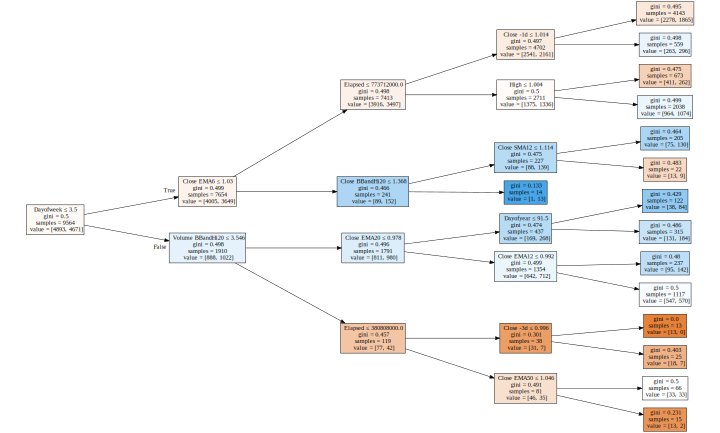

In [46]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [47]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[368, 802],
       [359, 861]], dtype=int64)

## Bagging

In [48]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=20, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.8484943538268507, 0.5108786610878661, 0.5313676286072773]


In [49]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[547, 623],
       [546, 674]], dtype=int64)

In [50]:
metrics.accuracy_score(y_valid, y_pred)

0.5108786610878661

In [51]:
metrics.precision_score(y_valid, y_pred)

0.5196607555898227

In [52]:
metrics.recall_score(y_valid, y_pred)

0.5524590163934426

In [53]:
metrics.f1_score(y_valid, y_pred)

0.5355582042113627

In [54]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
cnf_matrix[1:].sum() / cnf_matrix.sum()

0.5104602510460251

In [55]:
fi = rf_feat_importance(m, df)

In [56]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

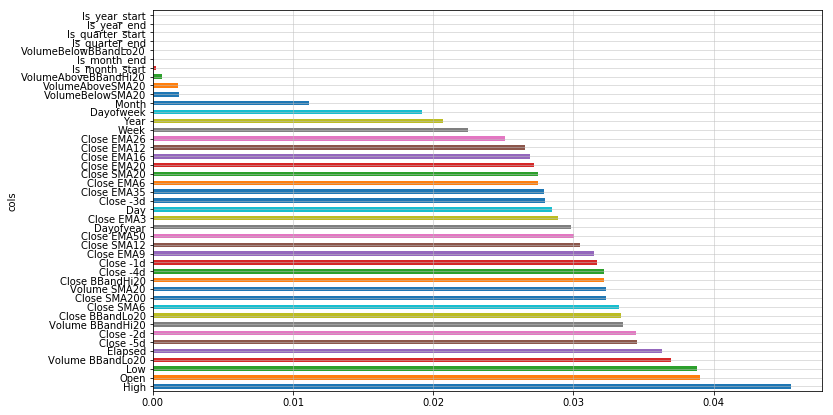

In [57]:
plot_fi(fi)

Looks Volume info might be somewhat useful, try adding history (-1d, -2d, etc.?)

Some things to try: 
- Add in OHL booleans such as: OpenHigherThanPreviousClose, OpenLowerThanPreviousClose, CloseIsHigh, CloseIsLow, OpenIsHigh, OpenIsLow
- Add in OHL history (-1d, -2d, etc.)
- Add in "Bollinger Band" with +/-1 STD (in addition to standard BBand which is +/-2 STD)